<img src="../images/immune.jpeg"  width="30%" height="15%">

# 03 - Creación y entrenamiento de una red neuronal con Tensorflow


![tensorflow](../images/tensorflow.jpeg)

### Primero un poco de teoría

![node](../images/node.png)


![neural](../images/neural.jpg)

### Convolucionales

https://en.wikipedia.org/wiki/Convolution


![neural2](../images/neural2.webp)

![neural3](../images/neural3.gif)

![neural4](../images/neural4.png)


https://towardsdatascience.com/a-comprehensible-explanation-of-the-dimensions-in-cnns-841dba49df5e

# Entrenamiento del modelo (ajuste)

In [1]:
#%pip install tensorflow --upgrade --user

In [2]:
#%pip install keras --upgrade

In [3]:
#%pip install imutils

In [4]:
#%pip install visualkeras

In [5]:
#%pip install opencv-python

In [1]:
# librerias
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input

from keras.models import Model

from keras.optimizers.legacy import Adam


from keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical


from imutils import paths
import visualkeras
from IPython.display import Image

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as report
import datetime

**Cargando y preparando datos**

In [2]:
imagenes=list(paths.list_images(f'../data/dataset_fuego'))

In [3]:
imagenes[0]

'../data/dataset_fuego\\con_fuego\\1.jpg'

In [4]:
Image(url=imagenes[0], width=300)

In [6]:
# preparando datos

data=[]
etiquetas=[]

for img in imagenes:
    
    # etiqueta segun nombre del archivo
    if 'con_' in img:
        etiquetas.append([0])  # con tema
    else:
        etiquetas.append([1])  # sin tema
    
    
    # carga la imagen (224x224) y procesala
    imagen=load_img(img, target_size=(224, 224))
    imagen=img_to_array(imagen)
    imagen=preprocess_input(imagen)

    # añade a la lista
    data.append(imagen)
    

    
# se convierten datos y etiquetas a arrays de numpy
data=np.array(data, dtype='float32')
etiquetas=np.array(etiquetas)

In [7]:
data[0].shape

(224, 224, 3)

In [8]:
etiquetas[0]

array([0])

In [9]:
# one hot para las etiquetas

etiquetas=to_categorical(etiquetas)

etiquetas[0]

array([1., 0.], dtype=float32)

In [10]:
# train-test split (separa datos de entrenamiento y testeo)

X_train, X_test, y_train, y_test=tts(data, 
                                     etiquetas, 
                                     test_size=.2, 
                                     stratify=etiquetas, 
                                     random_state=42)

In [11]:
X_train.shape

(2420, 224, 224, 3)

In [12]:
# aumenta datos con el generador de imagenes
# Crea nuevas imagenes rotando, transponiendo, haciendo zoom, etc.

img_gen=ImageDataGenerator(rotation_range=20, 
                           zoom_range=.15,
                           width_shift_range=.2, 
                           height_shift_range=.2,
                           shear_range=.15, 
                           horizontal_flip=True,
                           fill_mode='nearest')

## Modelo - Red Neuronal

Se creara el modelo con MobileNetV2, una red para reconocimiento de imagenes preentrenada.

**constantes**

In [14]:
TASA=1e-4    # tasa de aprendizaje

EPOCAS=5     # epocas de entrenamiento

BATCH=32     # tamaño del batch (muestra de datos que pasan a la red para entrenar)

**Red**

In [15]:
# se carga MobileNetV2 sin el clasificador
modelo_base=MobileNetV2(weights='imagenet', 
                        include_top=False, # LA ÚLTIMA CAPA LA PONGO YO
                        input_tensor=Input(shape=(224, 224, 3))) # UN CUBO DE 3 CAPAS DE 224, POR 224  PIXELES


# se contruye el nuevo clasificador
modelo_x=modelo_base.output

modelo_x=AveragePooling2D(pool_size=(7, 7))(modelo_x)

modelo_x=Flatten(name='flatten')(modelo_x)

modelo_x=Dense(128, activation='relu')(modelo_x)

modelo_x=Dropout(.5)(modelo_x) # Desconectamos capas para quitar el overfitting (aprender de memoria). Corta conexiones. Las conexiones que existen, se vuelven más eficientes.

modelo_x=Dense(2, activation='softmax')(modelo_x)



# se pone todo junto
modelo=Model(inputs=modelo_base.input, outputs=modelo_x)

In [16]:
# se congela el entrenamiento del modelo base, aprovechamos el preentreno
# Esas capas, los pesos que ya tienen déjalos como están, no los toques

for capa in modelo_base.layers:
    capa.trainable=False

In [17]:
# se compila el modelo

optimizador=Adam(lr=TASA, 
                 decay=TASA / EPOCAS)

modelo.compile(loss='binary_crossentropy', 
               optimizer=optimizador, 
               metrics=['accuracy'])

In [18]:
modelo.summary() # resumen de la red

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

EL AVERAGE PULLING Y LAS 5 ÚLTIMAS CAPAS SON LAS QUE SE HAN AÑADIDO MANUALMENTE A LA RED

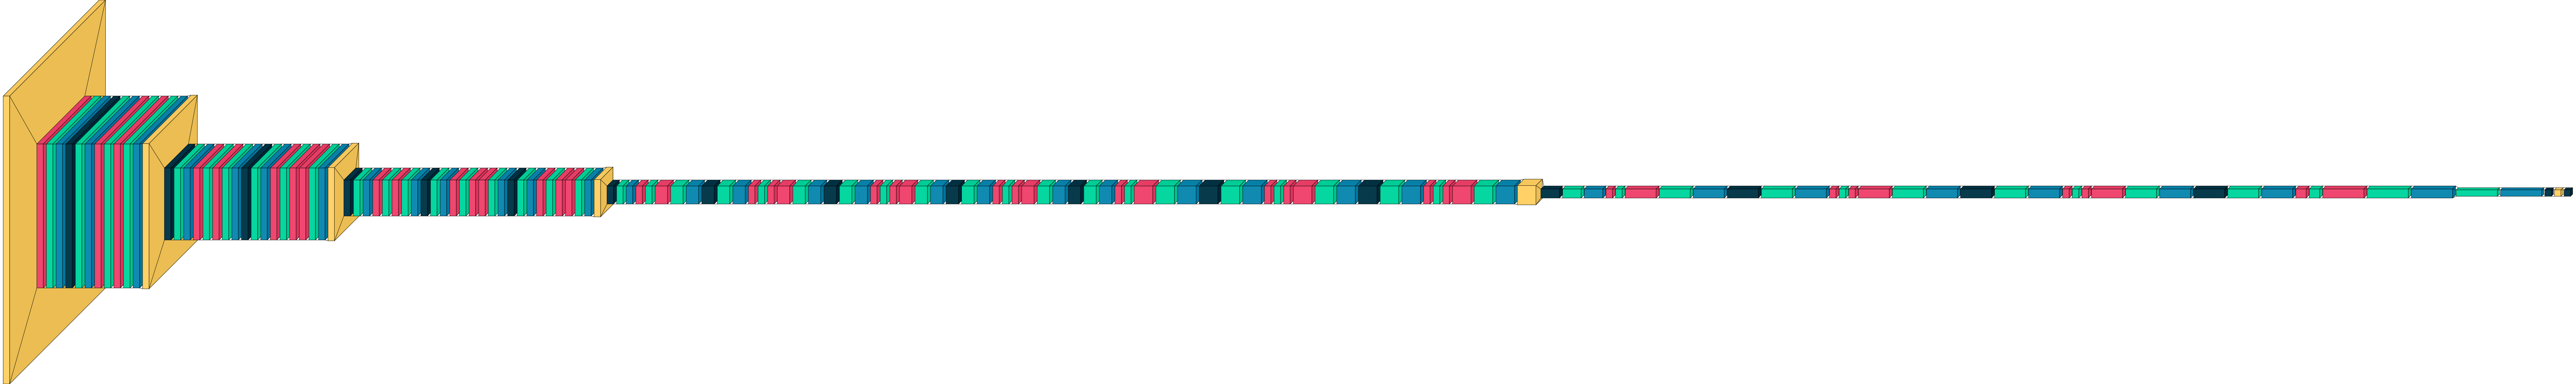

In [19]:
visualkeras.layered_view(modelo)

In [20]:
%%time

# se entrena el clasificador con las imagenes

print('Entrenando modelo...')

historico=modelo.fit(img_gen.flow(X_train, y_train, batch_size=BATCH), 
                     steps_per_epoch=len(X_train)//BATCH,
                     validation_data=(X_test, y_test), 
                     validation_steps=len(X_test)//BATCH, 
                     epochs=EPOCAS)

print('Entrenado.')

Entrenando modelo...
Epoch 1/5
75/75 [==============================] - 113s 1s/step - loss: 0.4746 - accuracy: 0.8044 - val_loss: 0.2478 - val_accuracy: 0.9175
Epoch 2/5
75/75 [==============================] - 102s 1s/step - loss: 0.2080 - accuracy: 0.9376 - val_loss: 0.1505 - val_accuracy: 0.9637
Epoch 3/5
75/75 [==============================] - 102s 1s/step - loss: 0.1607 - accuracy: 0.9472 - val_loss: 0.1159 - val_accuracy: 0.9703
Epoch 4/5
75/75 [==============================] - 101s 1s/step - loss: 0.1338 - accuracy: 0.9527 - val_loss: 0.0939 - val_accuracy: 0.9785
Epoch 5/5
75/75 [==============================] - 109s 1s/step - loss: 0.1278 - accuracy: 0.9577 - val_loss: 0.0983 - val_accuracy: 0.9703
Entrenado.
CPU times: total: 25min 38s
Wall time: 8min 47s


In [21]:
# haciendo predicciones
preds=modelo.predict(X_test, batch_size=BATCH)

preds[0]  # en probabilidad

19/19 [==============================] - 19s 961ms/step


array([1.0000000e+00, 4.0728477e-08], dtype=float32)

In [22]:
# la mayor prob de pertenencia, en 0/1
# Hay que coger el argumento máximo, dame el número que es el elemento máximo dentro del array
preds=np.argmax(preds, axis=1)

preds[0]  

0

In [23]:
# informe de clasificacion

print(report(y_test.argmax(axis=1), preds, target_names=['con_', 'sin_']))

              precision    recall  f1-score   support

        con_       0.95      1.00      0.98       354
        sin_       1.00      0.93      0.96       252

    accuracy                           0.97       606
   macro avg       0.98      0.96      0.97       606
weighted avg       0.97      0.97      0.97       606



In [24]:
# guardando modelo en formato h5

modelo.save(f'model/fuego.h5')


Quitar el generador de imagenes
Quitar el movilnet y usar otra de las redes de generamiento de imágenes. Movilnetv3, YOLO, IMAGENET. Mirarlas en keras.applications